In [1]:
import sys

sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from einops import repeat
from tasks.regression import RegressionICL
from data.regression import SinusoidalRegressionDataset

sns.set(style="white", context="notebook")
plt.rcParams["font.family"] = "Times New Roman"

# Plots

In [3]:
train_mse = pd.read_csv("data/train_mse.csv")
val_mse = pd.read_csv("data/val_mse.csv")
train_params_mse = pd.read_csv("data/train_params_mse.csv")
val_params_mse = pd.read_csv("data/val_params_mse.csv")
train_mse.head()

,epoch,Name: implicit - _step,Name: implicit - _step__MIN,Name: implicit - _step__MAX,Name: implicit - train/MSE,Name: implicit - train/MSE__MIN,Name: implicit - train/MSE__MAX,Name: explicit_transformerpred - _step,Name: explicit_transformerpred - _step__MIN,Name: explicit_transformerpred - _step__MAX,Name: explicit_transformerpred - train/MSE,Name: explicit_transformerpred - train/MSE__MIN,Name: explicit_transformerpred - train/MSE__MAX,Name: explicit_knownpred - _step,Name: explicit_knownpred - _step__MIN,Name: explicit_knownpred - _step__MAX,Name: explicit_knownpred - train/MSE,Name: explicit_knownpred - train/MSE__MIN,Name: explicit_knownpred - train/MSE__MAX
0,0,2,2,2,0.281656,0.249275,0.343018,2,2,2,0.320209,0.243524,0.473963,2,2,2,0.345033,0.244135,0.488455
1,1,4,4,4,0.227144,0.207818,0.258190,4,4,4,0.228212,0.205078,0.254659,4,4,4,0.187238,0.133500,0.240046
2,2,6,6,6,0.209546,0.198629,0.229064,6,6,6,0.202424,0.165820,0.227289,6,6,6,0.126048,0.086782,0.161657
3,3,8,8,8,0.197660,0.168740,0.210058,8,8,8,0.184802,0.132506,0.220825,8,8,8,0.091261,0.074761,0.130056
4,4,10,10,10,0.188594,0.157968,0.206947,10,10,10,0.154666,0.090788,0.219090,10,10,10,0.074542,0.067124,0.092316


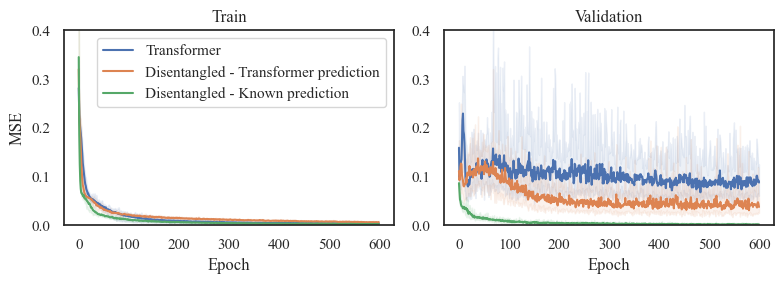

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
method_map = {
    "implicit": "Transformer",
    "explicit_transformerpred": "Disentangled - Transformer prediction",
    "explicit_knownpred": "Disentangled - Known prediction",
}
for i, (ax, split, df) in enumerate(
    zip(
        axs,
        ["train", "val"],
        [train_mse, val_mse],
    )
):
    df = df[df["epoch"] < 600]
    for j, method in enumerate(
        ["implicit", "explicit_transformerpred", "explicit_knownpred"]
    ):
        ax.fill_between(
            df["epoch"],
            df[f"Name: {method} - {split}/MSE__MIN"],
            df[f"Name: {method} - {split}/MSE__MAX"],
            color=sns.color_palette()[j],
            alpha=0.1,
        )
        sns.lineplot(
            x="epoch",
            y=f"Name: {method} - {split}/MSE",
            data=df,
            ax=ax,
            label=method_map[method],
        )
        ax.set(
            xlabel="Epoch",
            ylabel="MSE" if i == 0 else None,
            title={"train": "Train", "val": "Validation"}[split],
            ylim=(0, 0.4)
        )
    if i == 0:
        ax.legend(loc="upper right")
    else:
        ax.legend().remove()
fig.tight_layout()
fig.savefig("saved/mse.pdf")
plt.show()

# Function visualization

In [31]:
models = {
    "Transformer": RegressionICL.load_from_checkpoint("data/implicit - seed=0.ckpt").to(
        "mps"
    ),
    "Disentangled - Transformer prediction": RegressionICL.load_from_checkpoint(
        "data/explicit_transformerpred - seed=0.ckpt"
    ).to("mps"),
    "Disentangled - Known prediction": RegressionICL.load_from_checkpoint(
        "data/explicit_knownpred - seed=0.ckpt"
    ).to("mps"),
}

n_examples = 4
dataset = SinusoidalRegressionDataset(
    freqs=[2, 4, 8],
    max_amplitudes=[1, 0.5, 0.25],
    min_context=12,
    max_context=30,
    batch_size=1,
    data_size=1000,
    noise=0.0,
)
(x_c, y_c), _, params = dataset.get_batch(
    n_context=dataset.max_context, indices=range(n_examples)
)
x_c, y_c = x_c.to("mps"), y_c.to("mps")
x = torch.linspace(-4, 4, 100)
y = dataset.function(repeat(x, "c -> b c 1", b=n_examples), params).squeeze(-1)
ypred = {model: [] for model in models}
for model_name, model in models.items():
    for x_q in x:
        x_q = x_q * torch.ones(n_examples, 1, device="mps")
        with torch.no_grad():
            y_q_pred, _ = model(x_c, y_c, x_q)
        ypred[model_name].append(y_q_pred.squeeze(-1))
    ypred[model_name] = torch.stack(ypred[model_name], dim=1).cpu()
x_c, y_c = x_c.cpu().squeeze(-1), y_c.cpu().squeeze(-1)

/Users/eric/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.7
  rank_zero_warn(
/Users/eric/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


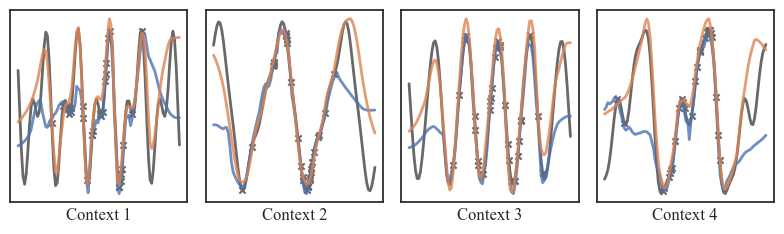

In [58]:
fig, axs = plt.subplots(1, n_examples, figsize=(2 * n_examples, 2.5))
for i in range(n_examples):
    ax = axs[i]
    ax.plot(x, y[i], label="True function", color="dimgray", linewidth=2)
    ax.scatter(x_c[i], y_c[i], s=20, label="Context points", color="dimgray", marker="x")
    for j, (model_name, ypred_model) in enumerate(ypred.items()):
        if model_name == "Disentangled - Known prediction":
            continue
        ypred_model = ypred_model[i]
        ax.plot(x, ypred_model, color=sns.color_palette()[j], linewidth=2, alpha=0.8)
    ax.set(xticks=[], yticks=[], xlabel=f"Context {i + 1}")
fig.tight_layout()
fig.savefig("saved/examples.pdf")
plt.show()